# ノイズバジェッティングと多チャンネル相関解析

精密計測（重力波検出器など）において、メインの観測データに含まれる雑音が「何に由来するのか」を特定することは極めて重要です。このプロセスを **Noise Budgeting（ノイズバジェッティング）** と呼びます。

このチュートリアルでは、以下の流れで解析を実演します。

1.  **データ生成**: メインチャンネルと、それに混入する環境ノイズ（補助チャンネル）をシミュレーションします。
2.  **コヒーレンス解析**: メインチャンネルと各補助チャンネルの相関を調べます。
3.  **伝達関数推定**: ノイズ源からメインチャンネルへの伝達関数 (Transfer Function) を推定します。
4.  **ノイズ投影 (Projection)**: 伝達関数を用いて、各ノイズ源がメインチャンネルにどれだけ寄与しているかを見積もります。
5.  **ノイズバジェット**: 全ての寄与を足し合わせ、トータルノイズを説明できるか確認します。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

from gwexpy import TimeSeries, TimeSeriesDict
from gwexpy.noise.colored import power_law
from gwexpy.noise.wave import from_asd, gaussian
from gwexpy.plot import Plot

plt.rcParams['figure.figsize'] = (12, 8)

## 1. 多チャンネルデータのシミュレーション

以下のチャンネルを含む `TimeSeriesDict` を作成します。

- `MAIN`: 観測チャンネル。基礎ノイズ（センシングノイズ）に加え、環境ノイズが混入しています。
- `PEM_SEIS`: 地面振動センサー（低周波で `MAIN` に混入）。
- `PEM_MAG`: 磁場センサー（電源ライン 60Hz ハーモニクスを含み、中周波で `MAIN` に混入）。
- `PEM_ELEC`: 回路ノイズ（広帯域で微小に混入）。

In [2]:
# パラメータ設定
duration = 64  # 秒
fs = 1024      # サンプリング周波数 (Hz)
t = np.arange(0, duration, 1/fs)

# 1. 補助チャンネル (ノイズ源) の生成
# 地面振動: 低周波で大きい (Red Noise)
seis_asd = power_law(1.5, amplitude=1e-5, f_ref=1, fmin=0.1, fmax=fs/2, df=1/duration)
pem_seis = from_asd(seis_asd, duration=duration, sample_rate=fs, name="PEM_SEIS")

# 磁場: 60Hz ラインノイズ + 白色雑音
pem_mag = gaussian(duration, fs, std=1e-3, name="PEM_MAG")
# 60Hzとその高調波を追加
for f in [60, 120, 180]:
    pem_mag += 5e-3 * np.sin(2 * np.pi * f * t)

# エレクトロニクス: 白色雑音
pem_elec = gaussian(duration, fs, std=1e-4, name="PEM_ELEC")

# 2. メインチャンネルへの混入 (Coupling)
# 地面振動の結合: 低周波のみ伝わる (Low-pass filter 的な結合)
coupling_seis = signal.butter(4, 10, 'low', fs=fs, output='sos')
noise_from_seis = signal.sosfilt(coupling_seis, pem_seis.value) * 0.1

# 磁場の結合: 特定の周波数で結合 (Band-pass)
coupling_mag = signal.butter(2, [55, 125], 'band', fs=fs, output='sos')
noise_from_mag = signal.sosfilt(coupling_mag, pem_mag.value) * 2.0

# 回路ノイズの結合: 定数ゲイン
noise_from_elec = pem_elec.value * 0.5

# センシングノイズ (外部環境とは無相関な基礎ノイズ)
sensing_limit = gaussian(duration, fs, std=1e-5)

# MAIN チャンネルの合成
main_data = sensing_limit.value + noise_from_seis + noise_from_mag + noise_from_elec
main = TimeSeries(main_data, sample_rate=fs, name="MAIN", unit="V")

# データをまとめる
data = TimeSeriesDict()
data["MAIN"] = main
data["PEM_SEIS"] = pem_seis
data["PEM_MAG"] = pem_mag
data["PEM_ELEC"] = pem_elec

print("シミュレーションデータ作成完了:", data)

シミュレーションデータ作成完了: TimeSeriesDict({'MAIN': <TimeSeries([-0.00011217,  0.00047169,  0.00277128, ...,
              0.00633071,  0.00417004,  0.00042266]
            unit=Unit("V"),
            t0=<Quantity 0. s>,
            dt=<Quantity 0.00097656 s>,
            name='MAIN',
            channel=None)>, 'PEM_SEIS': <TimeSeries([0.00016263, 0.00016287, 0.00016321, ..., 0.00016145,
             0.00016188, 0.00016235]
            unit=Unit("Hz(1/2)"),
            t0=<Quantity 0. s>,
            dt=<Quantity 0.00097656 s>,
            name='PEM_SEIS',
            channel=None)>, 'PEM_MAG': <TimeSeries([-0.00117037,  0.01076951,  0.01226937, ...,
             -0.00822087, -0.01293712, -0.00911082]
            unit=Unit(dimensionless),
            t0=<Quantity 0. s>,
            dt=<Quantity 0.00097656 s>,
            name='PEM_MAG',
            channel=None)>, 'PEM_ELEC': <TimeSeries([-4.18321985e-05, -5.64649227e-05, -1.30063829e-04,
             ..., -1.05219903e-04, -6.74240730e-05,
     

## 2. コヒーレンス解析 (Coherence)

`coherence()` メソッドを使って、MAIN チャンネルと各環境モニター間の相関（0〜1）を計算します。
コヒーレンスが高い周波数帯域は、その環境ノイズが MAIN に影響を与えている可能性が高いことを示唆します。

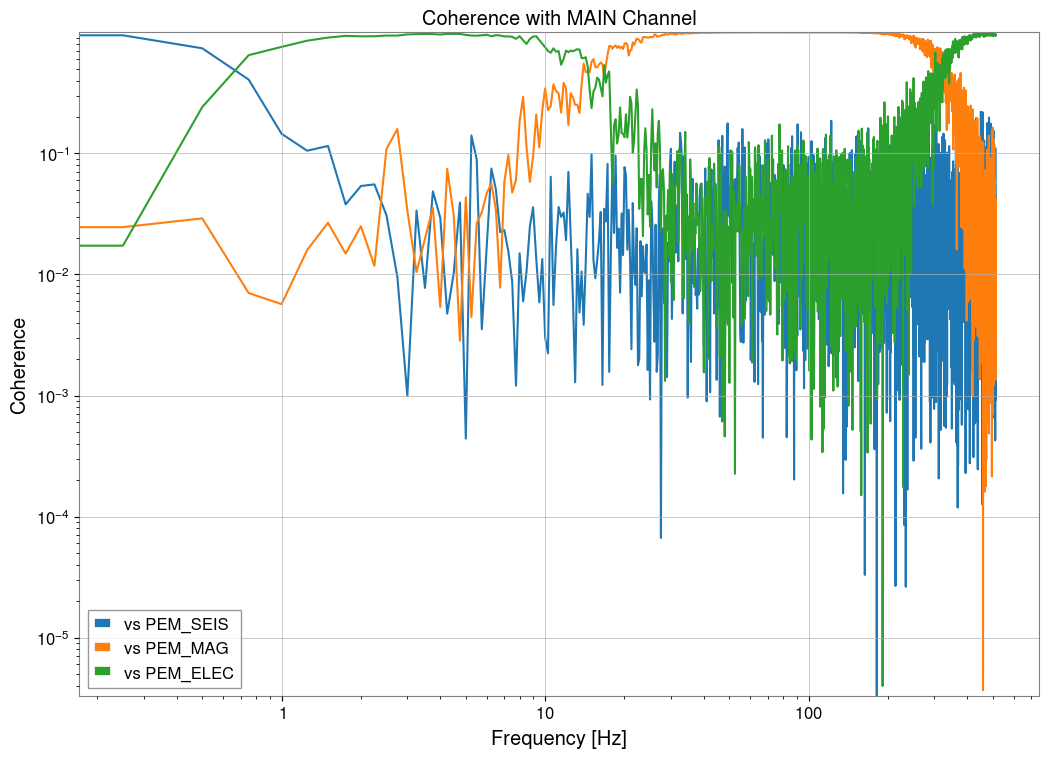

In [3]:
fftlength = 4
overlap = 2

# 各チャンネルとのコヒーレンスを計算
coh_seis = data["MAIN"].coherence(data["PEM_SEIS"], fftlength=fftlength, overlap=overlap)
coh_mag = data["MAIN"].coherence(data["PEM_MAG"], fftlength=fftlength, overlap=overlap)
coh_elec = data["MAIN"].coherence(data["PEM_ELEC"], fftlength=fftlength, overlap=overlap)

# プロット
plot = Plot(coh_seis, coh_mag, coh_elec,
            xscale='log',
            label=["vs PEM_SEIS", "vs PEM_MAG", "vs PEM_ELEC"],
            ylabel="Coherence",
            title="Coherence with MAIN Channel")
plot.show()

## 3. 伝達関数とノイズ投影 (Projection)

コヒーレンスがある場合、そのノイズがどれくらいの大きさで MAIN に現れているかを見積もります。
これには **伝達関数 (Transfer Function, TF)** を計算し、補助チャンネルのスペクトルに TF を掛けて **投影 (Projection)** します。

$$ \text{Projected Noise} = \text{ASD}_{\text{PEM}} \times |\text{TF}_{\text{PEM} \to \text{MAIN}}| $$

In [4]:
# 伝達関数の計算
tf_seis = data["PEM_SEIS"].transfer_function(data["MAIN"], fftlength=fftlength, overlap=overlap)
tf_mag = data["PEM_MAG"].transfer_function(data["MAIN"], fftlength=fftlength, overlap=overlap)
tf_elec = data["PEM_ELEC"].transfer_function(data["MAIN"], fftlength=fftlength, overlap=overlap)

# 各チャンネルの ASD を計算
asd_main = data["MAIN"].asd(fftlength=fftlength, overlap=overlap)
asd_seis = data["PEM_SEIS"].asd(fftlength=fftlength, overlap=overlap)
asd_mag = data["PEM_MAG"].asd(fftlength=fftlength, overlap=overlap)
asd_elec = data["PEM_ELEC"].asd(fftlength=fftlength, overlap=overlap)

# ノイズ投影 (Projection = ASD * |TF|)
proj_seis = asd_seis * tf_seis.abs()
proj_mag = asd_mag * tf_mag.abs()
proj_elec = asd_elec * tf_elec.abs()

# ラベル設定
proj_seis.name = "Proj. from Seismic"
proj_mag.name = "Proj. from Magnetic"
proj_elec.name = "Proj. from Electronics"
asd_main.name = "MAIN Measured"

## 4. ノイズバジェット (Noise Budget)

計算した各ノイズの寄与を足し合わせ（二乗和平均）、計測されたトータルノイズ (`measured`) と比較します。
一致すれば、ノイズの原因が特定できたことになります。

/home/washimi/miniforge3/envs/ws-base/lib/python3.12/site-packages/astropy/units/quantity.py:653: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


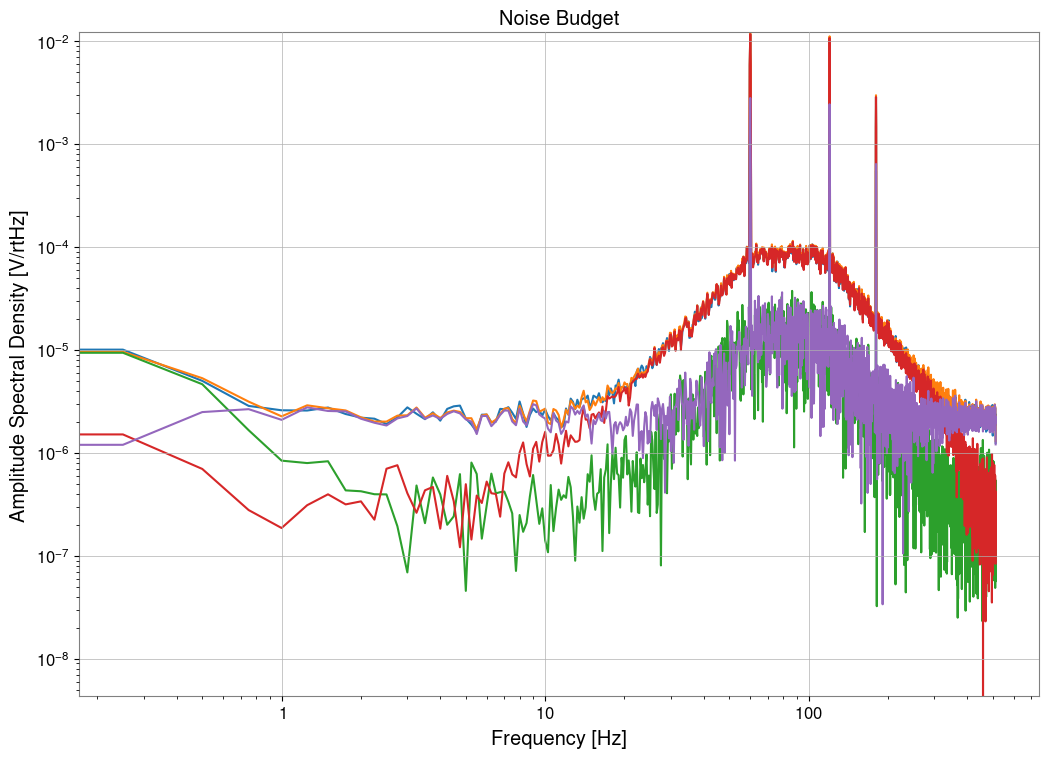

In [5]:
# ノイズの和 (Quadrature Sum: sqrt(a^2 + b^2 + ...))
# gwexpy の FrequencySeries は算術演算が可能
total_model = (proj_seis**2 + proj_mag**2 + proj_elec**2)**0.5
total_model.name = "Total Model (Sum of Projections)"

# センシング限界（残留ノイズ）
residual = (asd_main**2 - total_model**2)**0.5
residual.name = "Residual (Unexplained)"

# 最終プロット
plot = Plot(asd_main, total_model, proj_seis, proj_mag, proj_elec,
            xscale='log', yscale='log',
            ylabel="Amplitude Spectral Density [V/rtHz]",
            title="Noise Budget")
plot.show()